# Adjoint plugin test: Geometry Gradients

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FAdjoint.ipynb).

In [1]:
from typing import List

import numpy as np
import jax.numpy as jnp
import matplotlib.pylab as plt
from jax import grad, value_and_grad

import sys; sys.path.append('../../../tidy3d')
import tidy3d as td
import tidy3d.web as web

from tidy3d.plugins.adjoint.components.simulation import JaxSimulation
from tidy3d.plugins.adjoint.components.geometry import JaxBox
from tidy3d.plugins.adjoint.components.medium import JaxMedium
from tidy3d.plugins.adjoint.components.structure import JaxStructure
from tidy3d.plugins.adjoint.components.data.sim_data import JaxSimulationData
from tidy3d.plugins.adjoint.web import run

INFO:rich:Using client version: 1.8.0


In [2]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength

# resolution control
dl = 0.01
subpixel = True

# space between box and PML
buffer = 1.5 * wavelength

# initial size of box and waveguide
lx, ly, lz = .75, .75, .75
wg_width = 0.75

# position of source and monitor (constant for all)
source_x = -lx/2 - buffer/2
meas_x = lx/2 + buffer/2

# total size
Lx = lx + 2 * buffer
Ly = ly + 2 * buffer
Lz = lz + 2 * buffer
center0 = (0., 0.4 * ly/2., 0.4 * lz/2.)
size0 = (lx, ly, lz)

# simulation parameters
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

permittivity = 4.0
grid_spec = td.GridSpec.auto(wavelength=wavelength, min_steps_per_wvl=(wavelength/dl/np.sqrt(permittivity)))
# grid_spec = td.GridSpec.uniform(dl=dl)

wg_eps = 2.0

# frequency width and run time
freqw = freq0 / 10
run_time = 100 / freqw

# monitor for plotting
monitor_field = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="field_pattern",
)

In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, wg_width)),
    medium=td.Medium(permittivity=wg_eps)
)

num_modes = 2
mode_index_out = 1
mode_index_in = 0

mode_size = (0, 3, 3)

# source seeding the simulation
forward_source = td.ModeSource(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0/10),
        center=[source_x, 0.0, 0],
        size=mode_size,
        mode_index=mode_index_in,
        direction="+"
    )

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = 'measurement'

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, 0, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    name=measurement_monitor_name,
)

In [4]:
def make_input_structure(center=center0, size=size0) -> JaxStructure:
    return JaxStructure(
        geometry=JaxBox(center=center, size=size),
        medium=JaxMedium(permittivity=permittivity)
    )

In [5]:
def make_sim(center=center0, size=size0) -> JaxSimulation:
    """Make a simulation using a sequence of 4 permittivity values."""
    
    input_structure = make_input_structure(center, size)

    return JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=grid_spec,
        structures=[waveguide],
        input_structures=[input_structure],
        sources=[forward_source],
        output_monitors=[measurement_monitor],
        run_time=run_time,
        subpixel=subpixel,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        shutoff=1e-8,
        courant=0.9,
    )

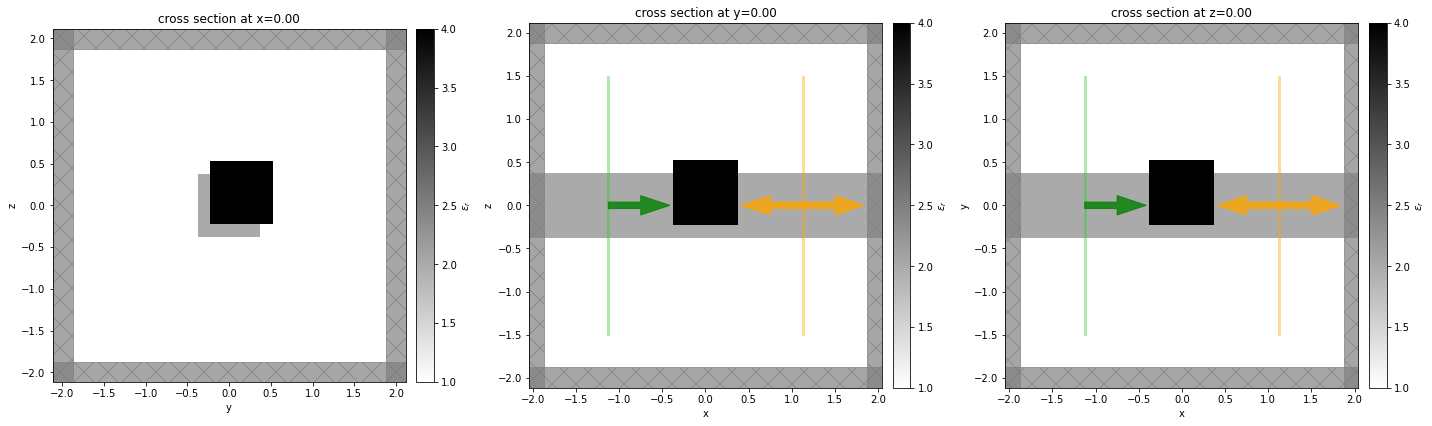

total cells in simulation = 1.5e+07


In [6]:
sim_base = make_sim()

f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(20, 15))

sim_plot = sim_base.to_simulation()[0]

for dim, ax in zip('xyz', axes):
    sim_plot.plot_eps(**{dim:0}, ax=ax)
    # sim_plot.plot_grid(**{dim:0}, ax=ax)

plt.show()

print(f"total cells in simulation = {sim_base.num_cells:.1e}")

Effective index of computed modes:  [[1.2283336 1.2276174]]


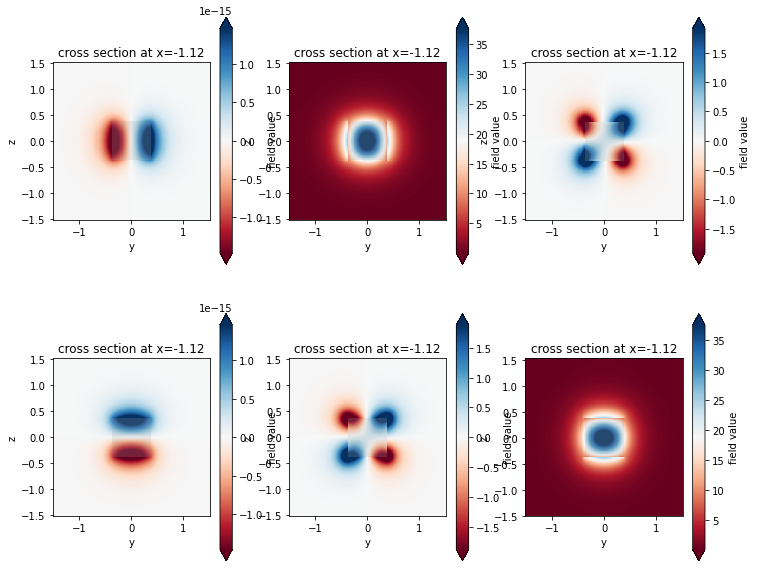

In [7]:
from tidy3d.plugins import ModeSolver

mode_solver = ModeSolver(simulation=sim_plot, plane=forward_source, mode_spec=sim_plot.monitors[0].mode_spec, freqs=[freq0])
modes = mode_solver.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(12, 5*num_modes))
for mode_ind in range(num_modes):
    mode_solver.plot_field("Ex", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    mode_solver.plot_field("Ey", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])
    mode_solver.plot_field("Ez", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 2])

In [8]:
def measure_power(sim_data: JaxSimulationData) -> float:
    """Power in the 0th order mode."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="+", f=freq0, mode_index=mode_index_out)
    return jnp.sum(jnp.abs(amp)**2)

In [9]:
def J(center, size) -> float:
    """Objective function, construct simulation, run it using adjoint plugin, and return power in mode_index=0."""
    sim = make_sim(center, size)
    sim_data = run(sim, task_name="shift_box")
    power_mode_0 = measure_power(sim_data)
    return power_mode_0

In [10]:
dJ_fn = grad(J, argnums=(0,1))

In [11]:
dcenter, dsize = grad_eval = dJ_fn(center0, size0)

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 99.4% • 23.3/23.5 MB • 3.0 MB/s • 0:00:01

INFO:rich:loading SimulationData from simulation_data.hdf5


In [12]:
grad_center_adj = np.array(dcenter)
grad_size_adj = np.array(dsize)
print("unnormalized:")
print(f"- Jax gradient (center): {grad_center_adj}")
print(f"- Jax gradient (size): {grad_size_adj}")
grad_jax = np.array(grad_eval).flatten()

unnormalized:
- Jax gradient (center): [2.5962479e-05 6.4943647e-03 6.4655645e-03]
- Jax gradient (size): [0.00983523 0.0056041  0.00557514]


In [13]:
grad_center_adj_normalized = grad_center_adj / np.linalg.norm(grad_center_adj)
grad_size_adj_normalized = grad_size_adj / np.linalg.norm(grad_size_adj)
print("normalized:")
print(f"- Jax gradient (center): {grad_center_adj_normalized}")
print(f"- Jax gradient (size): {grad_size_adj_normalized}")

normalized:
- Jax gradient (center): [0.00283306 0.70867354 0.7055308 ]
- Jax gradient (size): [0.77944565 0.4441271  0.44183204]


## Numerical Derivative

In [14]:
grad_num = None

if not grad_num:

    # delta = 0.5
    deltas = dict(center=0.01, size=0.01)
    # step size

    jax_sim_0 = make_sim(center=center0, size=size0)
    grid_spec0 = td.GridSpec(
        grid_x=td.CustomGrid(dl=jax_sim_0.grid.sizes.x), 
        grid_y=td.CustomGrid(dl=jax_sim_0.grid.sizes.y),
        grid_z=td.CustomGrid(dl=jax_sim_0.grid.sizes.z),
    )    
    _, jax_info = jax_sim_0.to_simulation()
    structure = jax_sim_0.input_structures[0]

    sims_batch_numerical = {}
    jax_info_dict = {}
    
    labels = ['center_0', 'center_1', 'center_2', 'size_0', 'size_1', 'size_2']

    for parameter_label in labels:

        for sign in (+1, -1):

            label, index = parameter_label.split('_')
            
            delta_ = deltas[label]
            
            structure = jax_sim_0.input_structures[0]
            dp = sign * delta_

            label, index = parameter_label.split('_')
            dp_array = [0,0,0]
            dp_array[int(index)] = dp

            if label == 'center':
                new_center = (np.array(structure.geometry.center) + dp_array).tolist()
                new_geometry = structure.geometry.copy(update=dict(center=new_center))
            else:
                new_size = (np.array(structure.geometry.size) + dp_array).tolist()
                new_geometry = structure.geometry.copy(update=dict(size=new_size))
            new_structure = structure.copy(update=dict(geometry=new_geometry))

            jax_sim_perturbed = jax_sim_0.copy(update=dict(input_structures=[new_structure]))
        
            jax_sim_perturbed = jax_sim_perturbed.copy(update=dict(grid_spec=grid_spec0))
            sim_perturbed, jax_info = jax_sim_perturbed.to_simulation()

            task_name = f'numerical_{parameter_label}_{sign}'
            sims_batch_numerical[task_name] = sim_perturbed
            # jax_info_dict[task_name] = jax_info

    # run a batch of each of these 8 calculations at once
    batch_data = web.Batch(simulations=sims_batch_numerical).run(path_dir='data')

    # power_info[i] stores the [-, +] perturbations of permittivities[i]
    power_info = [[None, None] for _ in range(len(labels))]

    for task_name, sim_data_delta in batch_data.items():
        jax_sim_data_delta = JaxSimulationData.from_sim_data(sim_data_delta, jax_info)

        # compute the objective function f(x) and add it to its proper spot in power_info
        power = measure_power(jax_sim_data_delta)
        split_task_name =  task_name.split('_')
        sign = float(split_task_name[-1])
        label_name = '_'.join(split_task_name[1:-1])
        label_index = labels.index(label_name)
        sign_index = 0 if sign < 0 else 1
        power_info[label_index][sign_index] = power

    grad_num = []
    for parameter_label, (power_minus, power_plus) in zip(labels, power_info):
        label, _ = parameter_label.split('_')
        delta_ = deltas[label]
        grad_num.append((power_plus - power_minus) / 2 / delta_)
    grad_num = np.array(grad_num)
    print('grad_num = [' + ', '.join([str(g) for g in grad_num]) + ']')

grad_num = np.array(grad_num)

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0% • 0.0/42.4 kB • ? • -:--:--

INFO:rich:loading SimulationData from data/8f3b559f-12b4-4e6a-8454-65e89ee0e68b.hdf5


grad_num = [6.344635e-07, 0.0053674597, 0.0053653494, 0.004835932, 0.0031661068, 0.003165059]


In [15]:
grad_center_num = grad_num[:3]
grad_size_num = grad_num[3:]

In [16]:
rms_error = np.linalg.norm(grad_num - grad_jax) / np.linalg.norm(grad_num)

print('numerical (unnormalized): ', grad_num)
print('using jax (unnormalized): ', grad_jax)
print(f'norm(diff) / norm(numerical): {(rms_error * 100):.3f} %')

numerical (unnormalized):  [6.3446350e-07 5.3674597e-03 5.3653494e-03 4.8359320e-03 3.1661068e-03
 3.1650590e-03]
using jax (unnormalized):  [2.5962479e-05 6.4943647e-03 6.4655645e-03 9.8352265e-03 5.6040990e-03
 5.5751395e-03]
norm(diff) / norm(numerical): 62.312 %


In [17]:
grad_jax / grad_num

array([40.92037  ,  1.2099513,  1.2050594,  2.033781 ,  1.7700285,
        1.7614646], dtype=float32)

In [18]:
grad_num_normalized = grad_num / np.linalg.norm(grad_num)
grad_jax_normalized = grad_jax / np.linalg.norm(grad_jax)
rms_error_normalized = np.linalg.norm(grad_num_normalized - grad_jax_normalized) / np.linalg.norm(grad_num_normalized)

print('numerical (normalized): ', grad_num_normalized)
print('using jax (normalized): ', grad_jax_normalized)
print(f'norm(diff) / norm(numerical): {(rms_error_normalized * 100):.3f} %')

numerical (normalized):  [6.3123764e-05 5.3401697e-01 5.3380698e-01 4.8113444e-01 3.1500092e-01
 3.1489667e-01]
using jax (normalized):  [0.00166481 0.4164417  0.41459495 0.6306696  0.3593547  0.35749772]
norm(diff) / norm(numerical): 23.277 %


In [19]:
print(f'- dl={dl:.2f}: norm(diff) / norm(numerical): {(rms_error_normalized * 100):.3f} %')

- dl=0.01: norm(diff) / norm(numerical): 23.277 %


In [20]:
grad_size_num_normalized = grad_size_num / np.linalg.norm(grad_size_num)
rms_error_size_normalized = np.linalg.norm(grad_size_num_normalized - grad_size_adj_normalized) / np.linalg.norm(grad_size_num_normalized)

print('size:')
print('\tnumerical (normalized): ', grad_size_num_normalized)
print('\tusing jax (normalized): ', grad_size_adj_normalized)
print(f'\tnorm(diff) / norm(numerical): {(rms_error_size_normalized * 100):.3f} %')

size:
	numerical (normalized):  [0.73382914 0.48044127 0.48028228]
	using jax (normalized):  [0.77944565 0.4441271  0.44183204]
	norm(diff) / norm(numerical): 6.984 %


In [21]:
grad_center_num_normalized = grad_center_num / np.linalg.norm(grad_center_num)
rms_error_center_normalized = np.linalg.norm(grad_center_num_normalized - grad_center_adj_normalized) / np.linalg.norm(grad_center_num_normalized)

# print(f'delta = {delta}')
print('grad_num = [' + ', '.join([str(g) for g in grad_num]) + ']')
print('')
print('size:')
print('\tnumerical (normalized): ', grad_size_num_normalized)
print('\tusing jax (normalized): ', grad_size_adj_normalized)
print(f'\tnorm(diff) / norm(numerical): {(rms_error_size_normalized * 100):.3f} %')

print('center: ')
print('\tnumerical (normalized): ', grad_center_num_normalized)
print('\tusing jax (normalized): ', grad_center_adj_normalized)
print(f'\tnorm(diff) / norm(numerical): {(rms_error_center_normalized * 100):.3f} %')

grad_num = [6.344635e-07, 0.0053674597, 0.0053653494, 0.004835932, 0.0031661068, 0.003165059]

size:
	numerical (normalized):  [0.73382914 0.48044127 0.48028228]
	using jax (normalized):  [0.77944565 0.4441271  0.44183204]
	norm(diff) / norm(numerical): 6.984 %
center: 
	numerical (normalized):  [8.360038e-05 7.072458e-01 7.069678e-01]
	using jax (normalized):  [0.00283306 0.70867354 0.7055308 ]
	norm(diff) / norm(numerical): 0.342 %
